In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import px4tools.ulog
import px4tools.version
import scipy.integrate

attempting to monkey patch pandas timedelta series plotting
monkey patch suceeded


In [3]:
pd.__version__

'0.19.2'

In [4]:
px4tools.version.git_revision

'16cafa6b2c52c5c067c65b4fba98685633a7c723'

In [5]:
p_gyro = {
    'rate': 250,
    'noise_density': 0.0003394,
    'random_walk': 3.8785e-05,
    'bias_correlation_time': 1000.0,
    'turn_on_bias_sigma': 0,#0.0087,
    'mean': 0,
}
p_accel = {
    'rate': 250,
    'noise_density': 0.004,
    'random_walk': 0.006,
    'bias_correlation_time': 300.0,
    'turn_on_bias_sigma': 0, #0.196,
    'mean': 0,
}
p_gyro, p_accel

({'bias_correlation_time': 1000.0,
  'mean': 0,
  'noise_density': 0.0003394,
  'random_walk': 3.8785e-05,
  'rate': 250,
  'turn_on_bias_sigma': 0},
 {'bias_correlation_time': 300.0,
  'mean': 0,
  'noise_density': 0.004,
  'random_walk': 0.006,
  'rate': 250,
  'turn_on_bias_sigma': 0})

In [6]:
def simulate(p, topic="t_sensor_gyro_0__f_x", verbose=False, tf=100):
    from numpy.random import randn
    d = []
    dt = 1.0/p['rate']
    tau = p['bias_correlation_time'] 
    sigma_w = p['noise_density'] 
    sigma_w_d = sigma_w/sqrt(dt)
    sigma_bias = p['random_walk']
    sigma_bias_d = sigma_bias*sqrt(tau/2*(1 -np.exp(-2*dt/tau)))
    i = 0
    x = p['turn_on_bias_sigma'] * randn()
    for t in np.arange(0, tf, dt):
        phi = np.exp(-dt/tau)
        x = phi*x + sigma_bias_d * randn()
        y = x + sigma_w_d * randn() + p['mean'] 
        d.append({
            'timestamp': t*1e6,
            topic : y
        })
        i += 1
        if i % int(1000/dt) == 0:
            if verbose:
                print(int(100*t/tf))
    df = pd.DataFrame(d)
    df.index = pd.TimedeltaIndex(df.timestamp/1e6, 's')
    return df

In [7]:
def simulate2(p, topic="t_sensor_gyro_0__f_x", verbose=False, tf=100):
    from numpy.random import randn
    d = []
    dt = 1.0/p['rate']
    tau = p['bias_correlation_time'] 
    sigma_w = p['noise_density'] 
    sigma_w_d = sigma_w/sqrt(dt)
    sigma_bias = p['random_walk']
    Q = sigma_bias**2
    K = tau
    Q_d = Q*K**2/(2*tau)*(1 - np.exp(-2*dt/tau))
    sigma_bias_d = sqrt(Q_d)
    i = 0
    x = p['turn_on_bias_sigma'] * randn()
    for t in np.arange(0, tf, dt):
        phi = np.exp(-dt/tau)
        x = phi*x + sigma_bias_d * randn()
        y = x + sigma_w_d * randn() + p['mean'] 
        d.append({
            'timestamp': t*1e6,
            topic : y
        })
        i += 1
        if i % int(1000/dt) == 0:
            if verbose:
                print(int(100*t/tf))
    df = pd.DataFrame(d)
    df.index = pd.TimedeltaIndex(df.timestamp/1e6, 's')
    return df

In [8]:
data_gyro = simulate(p_gyro, tf=3*3600)
data_gyro2 = simulate2(p_gyro, tf=3*3600)

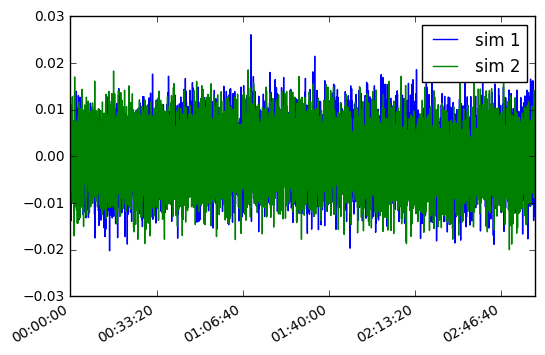

In [9]:
data_gyro.t_sensor_gyro_0__f_x.resample('1 s').ffill().plot(label='sim 1')
data_gyro2.t_sensor_gyro_0__f_x.resample('1 s').ffill().plot(label='sim 2')
gcf().autofmt_xdate()
plt.legend()

({'sig_bi': 0.00022896939063494763,
  'sig_rrw': 3.5190140808347255e-05,
  'sig_rw': 0.00028527542988322823,
  'tau_0': 0.88131792105178441,
  'tau_1': 14.041192429431785,
  'tau_2': 223.70484036571423},
 {'bias_correlation_time': 1000.0,
  'mean': 0,
  'noise_density': 0.0003394,
  'random_walk': 3.8785e-05,
  'rate': 250,
  'turn_on_bias_sigma': 0})

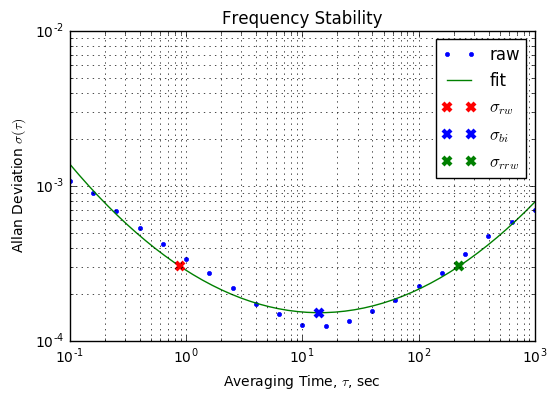

In [10]:
res_gyro = px4tools.ulog.plot_allan_std_dev(
    data_gyro.t_sensor_gyro_0__f_x.resample('100 ms').agg('mean'), poly_order=2)
legend(loc='best')
res_gyro, p_gyro

{'sig_bi': 2.8323923434317017e-07,
 'sig_rrw': 2.8481970929698742e-05,
 'sig_rw': 2.0963491358588092e-09,
 'tau_0': 0.00012104240839282888,
 'tau_1': 0.00012739735069419031,
 'tau_2': 0.00013463230205420758}

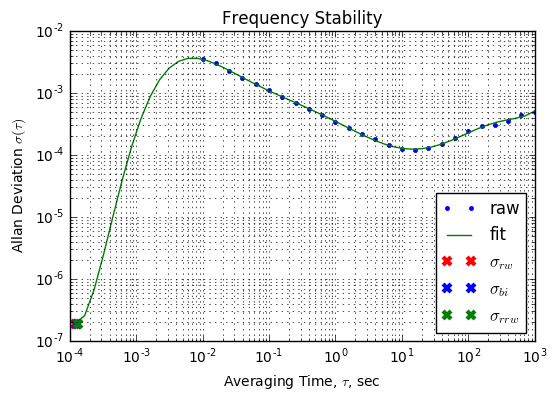

In [11]:
res = px4tools.ulog.plot_allan_std_dev(
    data_gyro2.t_sensor_gyro_0__f_x.resample('10 ms').agg('mean'), poly_order=8)
legend(loc='best')
res

1234.4513897789043

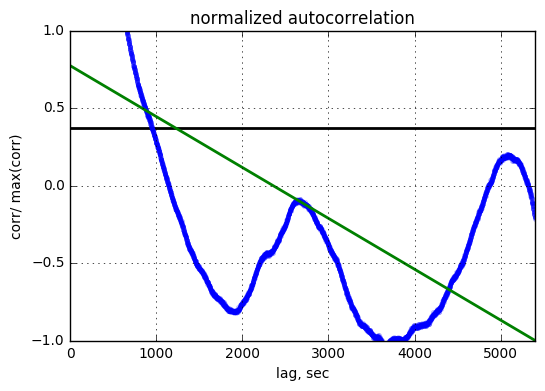

In [12]:
px4tools.ulog.plot_autocorrelation(data_gyro.t_sensor_gyro_0__f_x)

({'sig_bi': 0,
  'sig_rrw': 0,
  'sig_rw': 0.011957230391991935,
  'tau_0': 0.069931233686156002,
  'tau_1': nan,
  'tau_2': nan},
 1083.0333353710221)

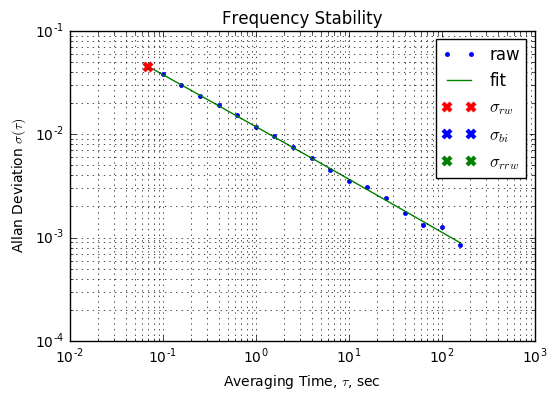

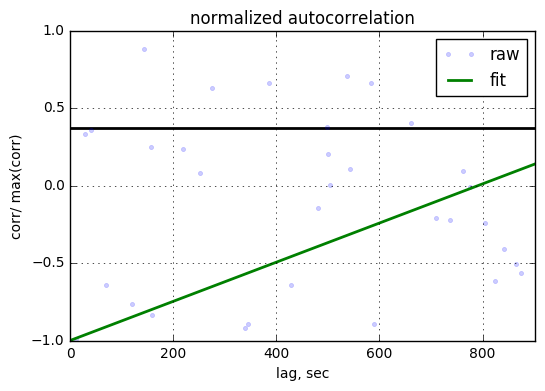

In [13]:
d_baro_f = px4tools.ulog.cached_log_processing(
    log='/home/jgoppert/.ros/rootfs/fs/microsd/log/2017-01-09/11_39_44.ulg',
    msg_filter='sensor_baro',
    processing_func=lambda x: x['sensor_baro_0'],
    save_path='./logs/01-09-17-sitl-baro_0_full.pkl',
    force_processing=False)
res_baro = px4tools.ulog.plot_allan_std_dev(d_baro_f.t_sensor_baro_0__f_altitude)
plt.legend()
figure()
tau_baro = px4tools.ulog.plot_autocorrelation(d_baro_f.t_sensor_baro_0__f_altitude)
plt.legend()
res_baro, tau_baro

In [14]:
res_baro

{'sig_bi': 0,
 'sig_rrw': 0,
 'sig_rw': 0.011957230391991935,
 'tau_0': 0.069931233686156002,
 'tau_1': nan,
 'tau_2': nan}

In [15]:
rate_baro = 1/(d_baro_f.timestamp.diff().mean()/1e6)
rate_baro

42.860931515234434

In [16]:
p_baro = {
    'rate': rate_baro,
    'noise_density': res_baro['sig_rw'],
    'random_walk':  res_baro['sig_rrw'],
    'bias_correlation_time': 10000,
    'mean':  d_baro_f.t_sensor_baro_0__f_altitude.mean(),
    'turn_on_bias_sigma':  0,
}
p_baro

{'bias_correlation_time': 10000,
 'mean': 0.10526131839555992,
 'noise_density': 0.011957230391991935,
 'random_walk': 0,
 'rate': 42.860931515234434,
 'turn_on_bias_sigma': 0}

In [17]:
d_baro_f.t_sensor_baro_0__f_altitude.mean()

0.10526131839555992

In [18]:
d_baro_sim = simulate(p_baro, topic="t_sensor_baro_0__f_altitude")

In [19]:
d_baro_sim2 = simulate2(p_baro, topic="t_sensor_baro_0__f_altitude")

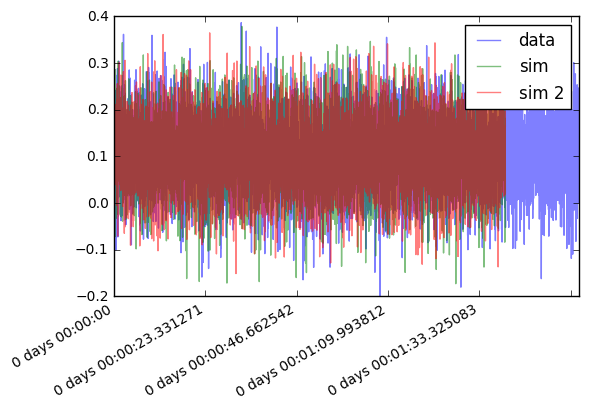

In [20]:
d_baro_f[:'1 m'].t_sensor_baro_0__f_altitude.plot(label='data', alpha=0.5)
d_baro_sim[:'1 m'].t_sensor_baro_0__f_altitude.plot(label='sim', alpha=0.5)
d_baro_sim2[:'1 m'].t_sensor_baro_0__f_altitude.plot(label='sim 2', alpha=0.5)
plt.legend()

In [42]:
import scipy.signal
import pandas

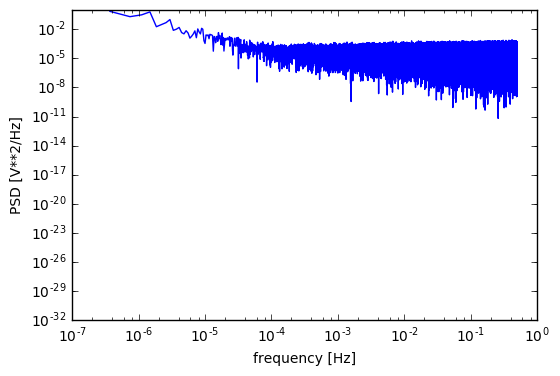

In [63]:
f, Pxx_den = scipy.signal.periodogram(
    data_gyro.t_sensor_gyro_0__f_x)
p = pandas.DataFrame(data=Pxx_den, index=f)
plt.loglog(f, p)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

{'sig_bi': 0.00026988970906923675,
 'sig_rrw': 3.3331312216083868e-05,
 'sig_rw': 0.00025116595669044336,
 'tau_0': 0.29513290902030986,
 'tau_1': 13.051757317540277,
 'tau_2': 577.19205100317606}

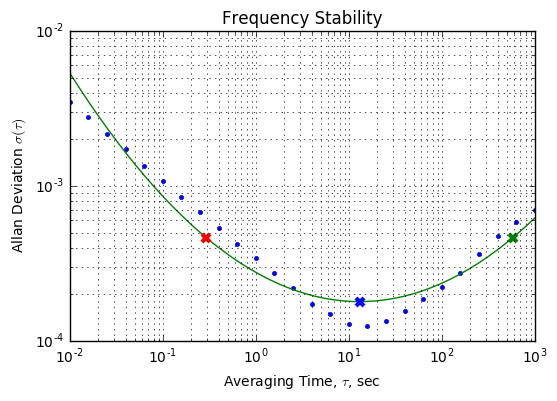

In [39]:
px4tools.plot_allan_std_dev(data_gyro.t_sensor_gyro_0__f_x)